In [1]:
import torch
import numpy as np
from torch import nn, einsum
import torch.nn.functional as f
import cv2
import matplotlib.pyplot as plt

import einops
from einops import rearrange, repeat

In [2]:
img = cv2.imread("../assets/annotated_image.jpg", cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (1024, 1024))
data = torch.tensor(img).unsqueeze(0).float()
data = data.permute(0, 3, 1, 2)
data.shape

torch.Size([1, 3, 1024, 1024])

In [3]:
import swin_T as swin
from importlib import reload
# reload(swin)
from swin_T import swin_t

In [4]:
backbone = swin_t()
# o1 = backbone(data)
# o1.shape


/home/schecter/miniconda3/envs/pikachu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class FeedForward(nn.Module):
    def __init__(self, hidden_dim, dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(), # activation function - gaussian error linear unit
            nn.Linear(hidden_dim, dim)
        )
        

    def forward(self, x):
        return self.network(x)

class CyclicShift(nn.Module):
    def __init__(self, disp):
        super().__init__()
        self.disp = disp

    def forward(self, x):
        return torch.roll(x, shifts=(self.disp, self.disp), dims=(1, 2))

def create_mask(window_size, displacement, upper_lower, left_right):
    mask = torch.zeros(window_size ** 2, window_size ** 2)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask

def get_rel_dist(window_size):
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))

    dist = indices[None, :, :] - indices[:, None, :]
    return dist

class WindowAttention(nn.Module):
    def __init__(self, dim, num_heads, head_dim, shifted, window_size, rel_pos_emb):
        super().__init__()
        # print("WindowAttention")
        inner_dim = head_dim * num_heads    #will be equal to number of channels sucj as (32*3 = 96 for the first layer)
        self.num_heads = num_heads
        self.scale = head_dim ** -0.5   #scale factor for the attention mechanism (1/sqrt(d_k))
        self.window_size = window_size  #for now, we will keep it as 7
        self.shifted = shifted
        self.rel_pos_emb = rel_pos_emb
        if self.shifted:
            disp = window_size // 2
            self.cyclic_shift = CyclicShift(-disp)
            self.cyclic_shift_rev = CyclicShift(disp)
        
            self.top_bottom_mask = nn.Parameter(create_mask(window_size=window_size, displacement=disp, upper_lower=True, left_right=False), requires_grad=False)
            self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=disp, upper_lower=False, left_right=True), requires_grad=False)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        # self.pos_emb = nn.Parameter(torch.randn(window_size**2, window_size**2))
        # this is realtive position embedding for the window size
        if self.rel_pos_emb:
            self.rel_ind = get_rel_dist(window_size) + window_size - 1
            self.pos_emb = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))
        else:
            self.pos_emb = nn.Parameter(torch.randn(window_size**2, window_size**2))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x, **kwargs):
        if self.shifted:
            x = self.cyclic_shift(x)

        batch, n_height, n_width, _, h = *x.shape, self.num_heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)

        num_window_h = n_height//self.window_size
        num_window_w = n_width//self.window_size

        q,k,v = map(lambda t: rearrange(t, 'batch (num_window_h w_h) (num_window_w w_w) (h d) -> batch h (num_window_h num_window_w) (w_h w_w) d', h=h, w_h=self.window_size, w_w=self.window_size), qkv)

        # this is a dot product similarity approch
        # dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

        # A better approch would be use the cosine similarity pointed out in the version 2 of the swin_t paper
        #  better because : it an be beneficial for object detection tasks when there are many similar objects (e.g., different bird species) that need to be distinguished.
        
        self.tau = nn.Parameter(torch.tensor(0.02), requires_grad=True)
        q = f.normalize(q, p=2, dim=-1)
        k = f.normalize(k, p=2, dim=-1)
        
        dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) / self.tau
        
        
        # here the possition embedding is added to all the rows
        # dots += self.pos_emb
        if self.rel_pos_emb:
            temp1 = self.rel_ind[:,:,0]
            dots += self.pos_emb[self.rel_ind[:,:,0], self.rel_ind[:,:,1]]
        else:
            dots += self.pos_emb

        if self.shifted:
            #here mask are being added to the last rows be it bpttom or right
            dots[:,:,-num_window_w:]+=self.top_bottom_mask
            dots[:,:,num_window_w-1::num_window_w] += self.left_right_mask

        attntion = dots.softmax(dim=-1)
        out = einsum('b h w i j, b h w j d -> b h w i d', attntion, v)
        out = rearrange(out, 'b h (num_window_h num_window_w) (w_h w_w) d -> b (num_window_h w_h) (num_window_w w_w) (h d)', h=h, w_h=self.window_size, w_w=self.window_size, num_window_h=num_window_h, num_window_w=num_window_w)
        out = self.to_out(out)

        if self.shifted:
            out = self.cyclic_shift_rev(out)

        return out

class PreNorm(nn.Module):
    def __init__(self, fn, dim):
        super().__init__()
        # print("attention block PreNorm")
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
        
    def forward(self, x, **kwargs):
        return self.norm(self.fn(x, **kwargs))  #this is different from the paper1 of swin whre the preNorm is applied before the mlp and attention

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        # print("atten_block Residual")
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class Swin_Block(nn.Module):
    def __init__(self, dim, num_heads, head_dim, mlp_dim, shifted,window_size, rel_pos_emb):
        super().__init__()
        # print("Swin_Block")
        self.attention_block = Residual(PreNorm(WindowAttention(dim=dim, num_heads=num_heads, head_dim=head_dim, shifted=shifted, window_size=window_size, rel_pos_emb=rel_pos_emb), dim))
        self.mlp_block = Residual(PreNorm(FeedForward(hidden_dim=mlp_dim, dim=dim), dim))
    

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        # print("returning from swin block")
        return x
        
# class PatchMerging_Conv(nn.Module):
#     def __init__(self, in_channels, out_channels, down_scaling_factor):
#         super().__init__()
#         self.patch_merge = nn.Conv2d(in_channels, out_channels, kernel_size=down_scaling_factor, stride=down_scaling_factor, padding=0)

#     def forward(self, x):
#         x = self.patch_merge(x).permute(0, 2, 3, 1)
#         return x
    
class UpMerging(nn.Module):
    def __init__(self, in_channels, stride=2, up_scaling_factor=2):
        super(UpMerging, self).__init__()
        self.pixel_shuffle = nn.PixelShuffle(stride)  # PixelShuffle with stride 2
        
    def forward(self, x):
        # Apply PixelShuffle to up-sample the feature maps
        x = self.pixel_shuffle(x)
        x = torch.cat([x, x], dim=1)
        return x.permute(0, 2, 3, 1)

class StageModule(nn.Module):
    def __init__(self, in_channel, hid_dim, layers, up_scaling_factor, num_heads, head_dim, window_size, rel_pos_emb, upsample=True):
        super().__init__()
        assert layers % 2 == 0, 'number of layers should be even'
        # self.patch_partition = PatchMerging_Conv(in_channels=in_channel, out_channels=hid_dim, down_scaling_factor=up_scaling_factor)
        self.layers = nn.ModuleList([])
        for _ in range(layers//2):
            self.layers.append(nn.ModuleList([
                Swin_Block(dim=in_channel, num_heads=num_heads, head_dim=head_dim, mlp_dim = hid_dim*4, shifted=False ,window_size=window_size, rel_pos_emb=rel_pos_emb),
                Swin_Block(dim=in_channel, num_heads=num_heads, head_dim=head_dim, mlp_dim = hid_dim*4, shifted=True ,window_size=window_size, rel_pos_emb=rel_pos_emb),
            ]))

        self.up_sample = UpMerging(in_channels=in_channel, up_scaling_factor=up_scaling_factor)
        self.upsample_bool = upsample

    def forward(self, x):
        # x = self.patch_partition(x)
        for regular, shifted in self.layers:
            x = regular(x)
            x = shifted(x)
            print("SWIN", x.shape)
            if self.upsample_bool:
                x = self.up_sample(x.permute(0,3,1,2))
                print("UPSAMPLE", x.shape)       
        return x

class SwinTransformer(nn.Module):
    def __init__(self, *, hid_dim, layers, heads, channels, num_classes=1, head_dim=32, window_size=2, up_scaling_fact=(4,2,2,2), rel_pos_emb = True):
      super().__init__()
      self.stage1 = StageModule(in_channel = channels, hid_dim=hid_dim, layers=layers[0], up_scaling_factor=up_scaling_fact[0], num_heads=heads[0], head_dim=head_dim, window_size=window_size, rel_pos_emb=rel_pos_emb)
      self.stage2 = StageModule(in_channel = channels//(2), hid_dim=hid_dim*2, layers=layers[1], up_scaling_factor=up_scaling_fact[1], num_heads=heads[1], head_dim=head_dim, window_size=window_size, rel_pos_emb=rel_pos_emb)
      self.stage3 = StageModule(in_channel = channels//(2*2), hid_dim=hid_dim*4, layers=layers[2], up_scaling_factor=up_scaling_fact[2], num_heads=heads[2], head_dim=head_dim, window_size=window_size, rel_pos_emb=rel_pos_emb)
      self.stage4 = StageModule(in_channel = channels//(2*2*2), hid_dim=hid_dim*8, layers=layers[3], up_scaling_factor=up_scaling_fact[3], num_heads=heads[3], head_dim=head_dim, window_size=window_size, rel_pos_emb=rel_pos_emb, upsample=False)

    #   self.mlp_head = nn.Sequential(
    #         nn.LayerNorm(hid_dim*8),
    #         nn.Linear(hid_dim*8, num_classes)
    #     )
    
    def forward(self, image):
        x = self.stage1(image)
        print("Exited stage 1")
        x = self.stage2(x)
        print("Exited stage 2")
        x = self.stage3(x)
        print("Exited stage 3")
        x = self.stage4(x)
        print("Exited stage 4")
        return x

def swin_t_neck(hid_dim=96, layers=(2, 2, 2, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hid_dim=hid_dim, layers=layers, heads=heads, **kwargs)

In [6]:
# import numpy as np

In [7]:
neck = swin_t_neck(channels = 768)
# o2 = neck(o1.permute(0, 2, 3, 1))
# o2.shape

In [8]:
import torch
temp = torch.randn(1, 256, 256, 96)
img = torch.randn(1, 3, 1024, 1024)

In [9]:
import torch.nn as nn

class CenterNetDetectionHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CenterNetDetectionHead, self).__init__()
        self.num_classes = num_classes
        
        # Convolutional layers for heatmap prediction
        self.conv_heatmap = nn.Conv2d(in_channels, num_classes, kernel_size=3, padding=1)
        
        # Convolutional layers for width prediction
        self.conv_width = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)
        
        # Convolutional layers for height prediction
        self.conv_height = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)
        
        # Convolutional layers for offset prediction
        self.conv_offset = nn.Conv2d(in_channels, 2, kernel_size=3, padding=1)
        
        # Activation functions
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        print(x.shape)
        print(self.num_classes)
        heatmap = self.conv_heatmap(x)
        width = self.conv_width(x)
        height = self.conv_height(x)
        offset = self.conv_offset(x)
        
        heatmap = self.sigmoid(heatmap)
        width = self.relu(width)
        height = self.relu(height)
        
        return heatmap, width, height, offset

In [10]:
class CustomObjectDetectionModel(nn.Module):
    def __init__(self, backbone, neck, object_detection_head):
        super(CustomObjectDetectionModel, self).__init__()
        self.backbone = backbone
        self.neck = neck
        self.object_detection_head = object_detection_head
    
    def forward(self, x):
        features = self.backbone(x)
        features = self.neck(features.permute(0, 3, 1, 2))
        detection_output = self.object_detection_head(features)
        return detection_output

In [11]:
# Instantiate the complete model
head = CenterNetDetectionHead(in_channels=96, num_classes=1)
model = CustomObjectDetectionModel(backbone, neck, head)

In [12]:
heatmap, width, height, offset = head(temp.permute(0, 3, 1, 2))

torch.Size([1, 96, 256, 256])
1


In [13]:
heatmap.shape, width.shape, height.shape, offset.shape

(torch.Size([1, 1, 256, 256]),
 torch.Size([1, 1, 256, 256]),
 torch.Size([1, 1, 256, 256]),
 torch.Size([1, 2, 256, 256]))

In [14]:
img = cv2.cvtColor(cv2.imread("../data/mva2023_sod4bird_train/images/00001.jpg"), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (1024, 1024))
data = torch.tensor(img).unsqueeze(0).float()
data = data.permute(0, 3, 1, 2)
data.shape

torch.Size([1, 3, 1024, 1024])

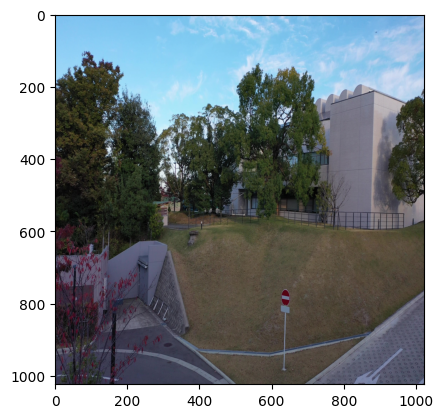

In [15]:
plt.imshow(img)

In [16]:
backbone_out = backbone(data)
backbone_out.shape

torch.Size([1, 768, 32, 32])

In [17]:
neck_out = neck(backbone_out.permute(0, 2, 3, 1))
neck_out.shape

SWIN torch.Size([1, 32, 32, 768])
UPSAMPLE torch.Size([1, 64, 64, 384])
Exited stage 1
SWIN torch.Size([1, 64, 64, 384])
UPSAMPLE torch.Size([1, 128, 128, 192])
Exited stage 2
SWIN torch.Size([1, 128, 128, 192])
UPSAMPLE torch.Size([1, 256, 256, 96])
Exited stage 3
SWIN torch.Size([1, 256, 256, 96])
Exited stage 4


torch.Size([1, 256, 256, 96])

In [18]:
head_out = head(neck_out.permute(0, 3, 1, 2))
heatmap, width, height, offset = head_out

torch.Size([1, 96, 256, 256])
1


In [19]:
heatmap.shape

torch.Size([1, 1, 256, 256])

In [20]:
temp_heatmap = einops.rearrange(heatmap, 'b c h w -> h (w c b)')

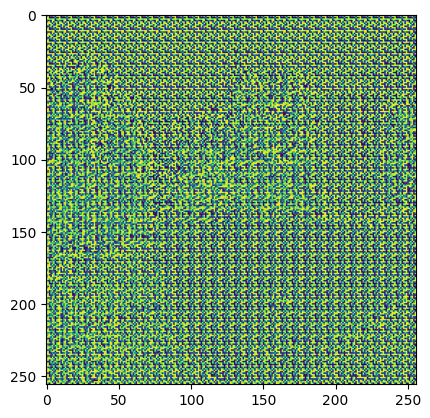

In [21]:
plt.imshow(temp_heatmap.detach().numpy())
plt.show()

In [22]:
width.shape, height.shape, offset.shape

(torch.Size([1, 1, 256, 256]),
 torch.Size([1, 1, 256, 256]),
 torch.Size([1, 2, 256, 256]))

In [23]:
temp_width = einops.rearrange(width, 'b c h w -> h (w c b)')
temp_height = einops.rearrange(height, 'b c h w -> h (w c b)')

In [24]:
temp_offset = einops.rearrange(offset, 'b c h w -> (c b) h w ')

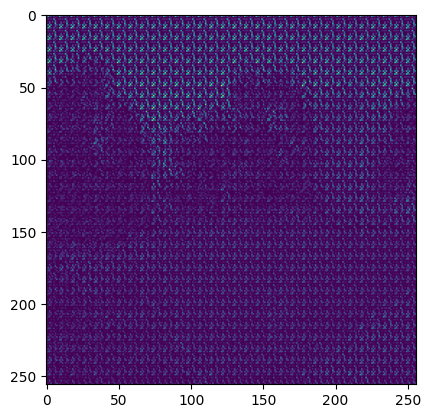

In [25]:
plt.imshow(temp_width.detach().numpy())
plt.imshow(temp_height.detach().numpy())
plt.show()

In [26]:
import numpy as np

def find_objects(heatmap, width, height, offset, heatmap_threshold=0.7):
    # Threshold the heatmap
    heatmap[heatmap < heatmap_threshold] = 0
    
    # Find local maxima in the heatmap
    object_centers = peak_detection(heatmap)
    # print(f"Shape OC: {object_centers.shape}")
    # Generate bounding boxes for each detected object center
    bounding_boxes = []
    for center in object_centers:
        # Get the width, height, and offset predictions at the center location
        # print(f"Center: {center}")
        center_x, center_y = center
        center_x = int(center_x)
        center_y = int(center_y)
        predicted_width = width[center_y, center_x].item()
        predicted_height = height[center_y, center_x].item()
        offset_x = offset[0, center_y, center_x].item()
        offset_y = offset[1, center_y, center_x].item()
        
        # Calculate the bounding box coordinates
        bbox_x1 = (center_x - predicted_width / 2) + offset_x
        bbox_y1 = (center_y - predicted_height / 2) + offset_y
        bbox_x2 = (center_x + predicted_width / 2) + offset_x
        bbox_y2 = (center_y + predicted_height / 2) + offset_y
        
        # Add the bounding box to the list
        bounding_boxes.append([bbox_x1, bbox_y1, bbox_x2, bbox_y2])
    
    return bounding_boxes

def peak_detection(heatmap):
    # Implement peak detection algorithm (e.g., non-maximum suppression)
    # This function should return a list of detected object centers
    # For simplicity, let's assume it returns all non-zero coordinates in the heatmap
    object_centers = np.argwhere(heatmap > 0)
    return object_centers

In [27]:
bb = find_objects(temp_heatmap.detach().numpy(), temp_width.detach().numpy(), temp_height.detach().numpy(), temp_offset.detach().numpy())

In [28]:
import torch
import torch.nn as nn

# Assuming neck_out is a torch.Tensor variable

# Define the convolutional layer
conv = nn.Conv2d(in_channels=neck_out.shape[1], out_channels=1, kernel_size=3)

# Perform the convolution
conv_out = conv(neck_out)


In [29]:
conv_out.shape

torch.Size([1, 1, 254, 94])

In [30]:
temp_heatmap = einops.rearrange(heatmap, 'b c h w -> h (w c b)')

In [31]:
temp_heatmap.shape

torch.Size([256, 256])

In [32]:
offset.shape

torch.Size([1, 2, 256, 256])

In [33]:
print(offset[0].shape)

torch.Size([2, 256, 256])


In [34]:
print(temp_heatmap.detach().numpy().shape)

(256, 256)


In [35]:
print(np.array(bb).shape)

(32381, 4)


In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_bboxes(image, bboxes, class_labels=None):
    """
    Plot bounding boxes on the input image.
    
    Parameters:
        image (numpy.ndarray): Input image as a NumPy array.
        bboxes (list): List of bounding box coordinates in the format [x1, y1, x2, y2].
        class_labels (list): List of class labels corresponding to each bounding box.
    """
    # Create figure and axis
    fig, ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(image)
    
    # Plot each bounding box
    for bbox_idx, bbox in enumerate(bboxes):
        x1, y1, x2, y2 = bbox
        
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add class label if available
        if class_labels is not None:
            ax.text(x1, y1, class_labels[bbox_idx], color='r', fontsize=8, ha='left', va='bottom')
    
    # Show plot
    plt.show()

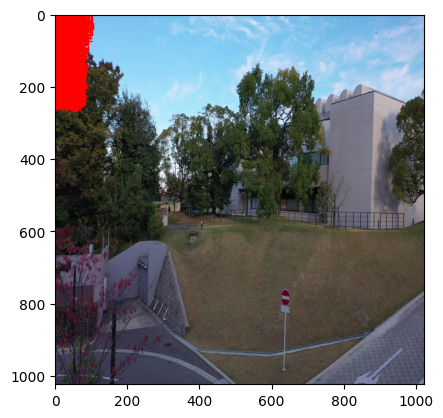

In [37]:
plot_bboxes(img, bb[:10000])

In [38]:
from neck import Neck
from backbone import Backbone

import torch
import torch.nn as nn

In [39]:
temp = torch.randn(1, 3, 1024, 1024)

In [40]:
backbone_model = Backbone(hid_dim=96, layers=(2, 2, 2, 2), heads=(3, 6, 12, 24))

In [41]:
backbone_out, feature_maps = backbone_model(temp)

In [42]:
backbone_out.shape

torch.Size([1, 768, 32, 32])

In [44]:
neck_model = Neck(hid_dim=96, layers=(2, 2, 2, 2), heads= (3, 6, 12, 64), channels=768, feature_maps=feature_maps)

In [45]:
for i in range(4):
    print(feature_maps[i].shape)

torch.Size([1, 96, 256, 256])
torch.Size([1, 192, 128, 128])
torch.Size([1, 384, 64, 64])
torch.Size([1, 768, 32, 32])


In [47]:
neck_out = neck_model(backbone_out.permute(0, 2, 3, 1))

Stage 1 torch.Size([1, 128, 128, 96])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16384x96 and 384x576)

In [ ]:
head_model = CenterNetDetectionHead(in_channels=96, num_classes=1)


In [ ]:
print(temp_width)

In [ ]:
print(temp_offset)

In [ ]:
print(temp_offset.shape)